In [1]:
ENV_LIST = ['Pendulum-v0', 'MountainCar-v0']
ENV_IDX = 0

In [2]:
import numpy as np
import random
from matplotlib import pyplot as plt

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
env = gym.make(ENV_LIST[ENV_IDX])

In [4]:
action_list = [4/10*i-2 for i in range(11)]

In [5]:
learning_rate = 1e-3

max_buff_size = 5000
batch_size = 32
gamma = 0.99

update_freq = 1000
print_freq = 500

In [6]:
def get_action(q_net, inputs, epsilon, action_dim=11):
    # randomly choose
    if random.random() <= epsilon:
        action_idx = random.randint(0, action_dim-1)
    else:
        q_value = q_net(inputs).tolist()
        action_idx = np.argmax(q_value)
    
    return action_idx

In [7]:
class QNet(nn.Module):
    def __init__(self, action_dim=11):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def calculate_loss(minibatch, gamma=0.99):
    rewards = torch.tensor((minibatch[:, 2]).astype(np.float32))
    done = torch.tensor((1-minibatch[:, 4]).astype(np.float32))
    next_q = target_net(torch.tensor(np.concatenate(minibatch[:,3], axis=0).reshape(-1, 3), dtype=torch.float32))
    next_q_max = next_q[torch.arange(batch_size), next_q.max(1)[1]]
    y_target = rewards + gamma * done * next_q_max
    #print('y target:', y_target)
    q_values = q_net(torch.tensor(np.concatenate(minibatch[:,0], axis=0).reshape(-1, 3), dtype=torch.float32))
    actions = minibatch[:, 1].astype(np.int32)
    max_q = q_values[torch.arange(batch_size), actions]
    #print('q:', max_q)
    loss = criterion(y_target, max_q)
    
    return loss

In [9]:
data_returns = []
data_average_loss = []
data_minibatch_loss = []
num_exp = 5

for ne in range(num_exp):
    print('Model #', ne+1, ' trainning..')
    q_net = QNet()
    target_net = QNet()
    target_net.load_state_dict(q_net.state_dict())
    criterion = nn.MSELoss(reduction='mean')
    #optimizer = optim.SGD(q_net.parameters(), lr=1e-6, momentum=0.95)
    optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)

    epsilon = 1.0
    min_epsilon = 0.01

    replay_buffer = []
    log_returns = []
    log_average_loss = []
    log_minibatch_loss = []

    done = False
    t_step = 0
    ridx = 0
    episode_reward = 0
    running_loss = 0
    observation = env.reset()

    while t_step<20000:
        #env.render()
        pre_obs = observation
        input_state = torch.tensor([observation], dtype=torch.float32)
        action_idx = get_action(q_net, input_state, epsilon)
        observation, reward, done, info = env.step([action_list[action_idx]])

        epsilon = max(0.999*epsilon, min_epsilon)

        episode_reward += reward
        if done:
            #print('new episode.')
            log_returns.append(episode_reward)
            episode_reward = 0
            observation = env.reset()

        if len(replay_buffer)<max_buff_size:
            replay_buffer.append([pre_obs, action_idx, reward, observation, done])
            if len(replay_buffer)<batch_size:
                continue
        else:
            replay_buffer[ridx%max_buff_size] = [pre_obs, action_idx, reward, observation, done]
            ridx += 1

        minibatch = np.array(random.sample(replay_buffer, batch_size))
        loss = calculate_loss(minibatch)
        running_loss += loss.data.numpy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (t_step+1)%print_freq==0:
            #print(t_step+1, 'step average loss:', running_loss/print_freq)
            log_average_loss.append(running_loss/print_freq)
            running_loss = 0
        log_minibatch_loss.append(loss.data.numpy())

        if (t_step+1)%update_freq:
            target_net.load_state_dict(q_net.state_dict())

        t_step += 1
    
    data_returns.append(log_returns)
    data_average_loss.append(log_average_loss)
    data_minibatch_loss.append(log_minibatch_loss)

Model # 1  trainning..
Model # 2  trainning..
Model # 3  trainning..
Model # 4  trainning..
Model # 5  trainning..


## Update Frequency: 1000

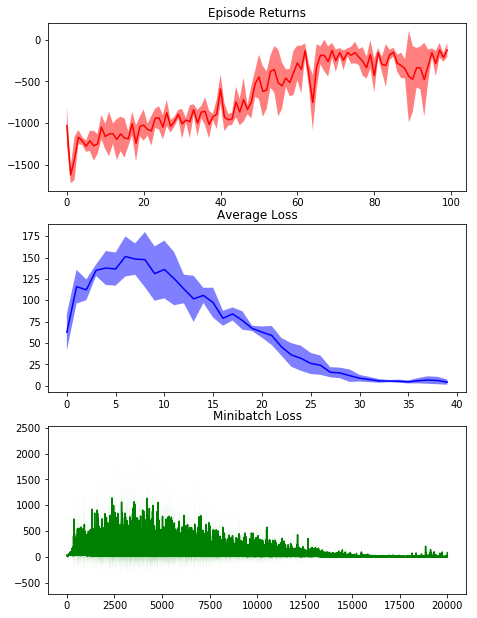

In [10]:
mu = []
sigma = []
labels = ['Episode Returns', 'Average Loss', 'Minibatch Loss']
colors = ['red', 'blue', 'green']
mu.append(np.array(data_returns[:4]).mean(axis=0))
mu.append(np.array(data_average_loss[:4]).mean(axis=0))
mu.append(np.array(data_minibatch_loss[:4]).mean(axis=0))
sigma.append(np.array(data_returns[:4]).std(axis=0))
sigma.append(np.array(data_average_loss[:4]).std(axis=0))
sigma.append(np.array(data_minibatch_loss[:4]).std(axis=0))

fig, axes = plt.subplots(3)
for i in range(3):
    axes[i].plot(np.arange(len(mu[i])), mu[i], label=labels[i], color=colors[i])
    axes[i].fill_between(np.arange(len(mu[i])), mu[i]+sigma[i], mu[i]-sigma[i], facecolor=colors[i], alpha=0.5)
    axes[i].set_title(labels[i])

fig.set_size_inches(7.5, 10.5)
# ax.set_title(r'random walkers empirical $\mu$ and $\pm \sigma$ interval')
# ax.legend(loc='upper left')
# ax.set_xlabel('num steps')
# ax.set_ylabel('position')
# ax.grid()

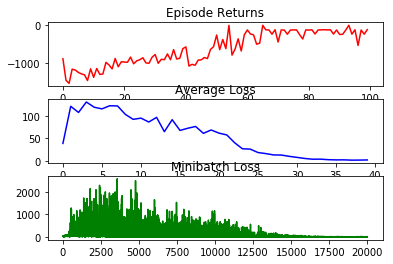

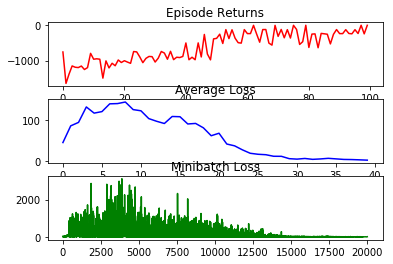

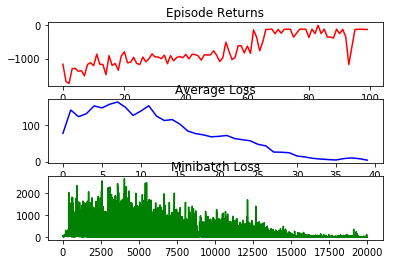

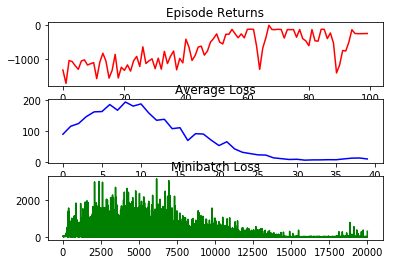

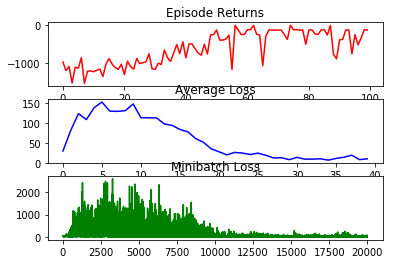

In [11]:
for ix in range(num_exp):
    fig, axes = plt.subplots(3)
    axes[0].plot(data_returns[ix], color=colors[0])
    axes[1].plot(data_average_loss[ix], color=colors[1])
    axes[2].plot(data_minibatch_loss[ix], color=colors[2])
    for i in range(3):
        axes[i].set_title(labels[i])

## Update Frequency: 100

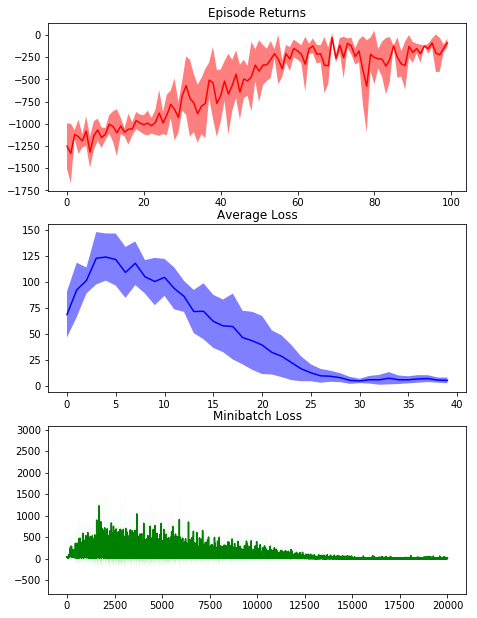

In [10]:
mu = []
sigma = []
labels = ['Episode Returns', 'Average Loss', 'Minibatch Loss']
colors = ['red', 'blue', 'green']
mu.append(np.array(data_returns[:4]).mean(axis=0))
mu.append(np.array(data_average_loss[:4]).mean(axis=0))
mu.append(np.array(data_minibatch_loss[:4]).mean(axis=0))
sigma.append(np.array(data_returns[:4]).std(axis=0))
sigma.append(np.array(data_average_loss[:4]).std(axis=0))
sigma.append(np.array(data_minibatch_loss[:4]).std(axis=0))

fig, axes = plt.subplots(3)
for i in range(3):
    axes[i].plot(np.arange(len(mu[i])), mu[i], label=labels[i], color=colors[i])
    axes[i].fill_between(np.arange(len(mu[i])), mu[i]+sigma[i], mu[i]-sigma[i], facecolor=colors[i], alpha=0.5)
    axes[i].set_title(labels[i])

fig.set_size_inches(7.5, 10.5)
# ax.set_title(r'random walkers empirical $\mu$ and $\pm \sigma$ interval')
# ax.legend(loc='upper left')
# ax.set_xlabel('num steps')
# ax.set_ylabel('position')
# ax.grid()

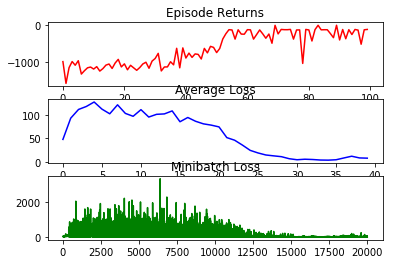

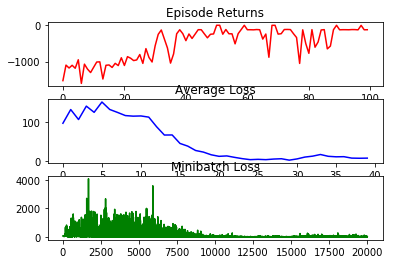

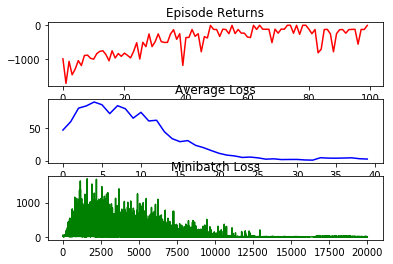

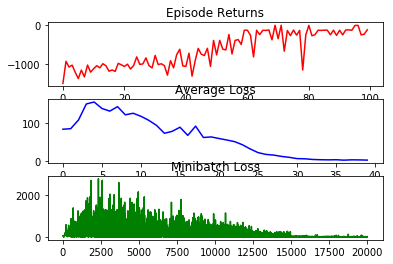

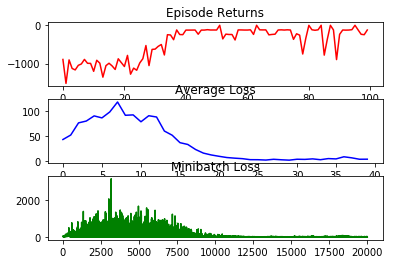

In [11]:
for ix in range(num_exp):
    fig, axes = plt.subplots(3)
    axes[0].plot(data_returns[ix], color=colors[0])
    axes[1].plot(data_average_loss[ix], color=colors[1])
    axes[2].plot(data_minibatch_loss[ix], color=colors[2])
    for i in range(3):
        axes[i].set_title(labels[i])

## Update Frequency: 10

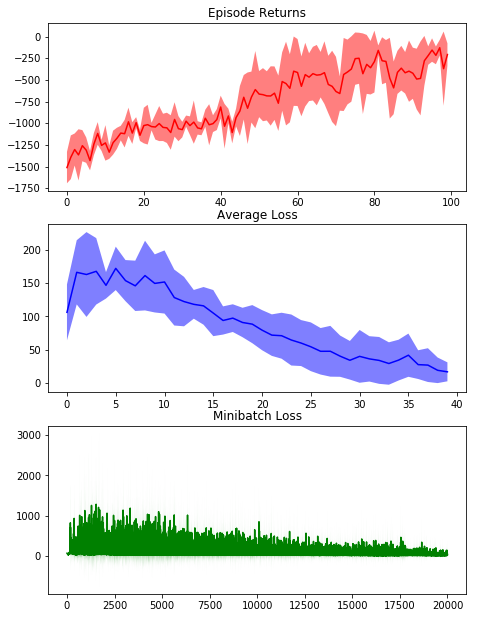

In [19]:
mu = []
sigma = []
labels = ['Episode Returns', 'Average Loss', 'Minibatch Loss']
colors = ['red', 'blue', 'green']
mu.append(np.array(data_returns[:4]).mean(axis=0))
mu.append(np.array(data_average_loss[:4]).mean(axis=0))
mu.append(np.array(data_minibatch_loss[:4]).mean(axis=0))
sigma.append(np.array(data_returns[:4]).std(axis=0))
sigma.append(np.array(data_average_loss[:4]).std(axis=0))
sigma.append(np.array(data_minibatch_loss[:4]).std(axis=0))

fig, axes = plt.subplots(3)
for i in range(3):
    axes[i].plot(np.arange(len(mu[i])), mu[i], label=labels[i], color=colors[i])
    axes[i].fill_between(np.arange(len(mu[i])), mu[i]+sigma[i], mu[i]-sigma[i], facecolor=colors[i], alpha=0.5)
    axes[i].set_title(labels[i])

fig.set_size_inches(7.5, 10.5)
# ax.set_title(r'random walkers empirical $\mu$ and $\pm \sigma$ interval')
# ax.legend(loc='upper left')
# ax.set_xlabel('num steps')
# ax.set_ylabel('position')
# ax.grid()

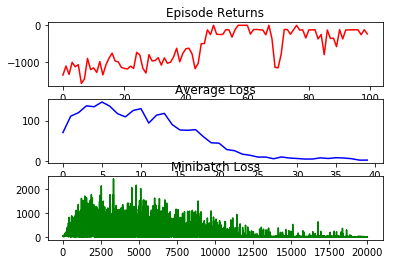

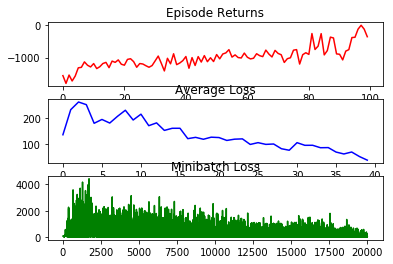

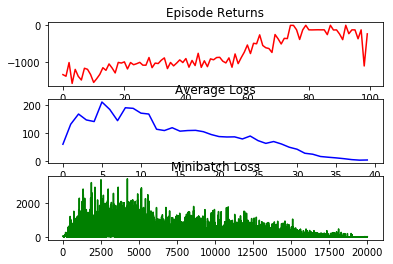

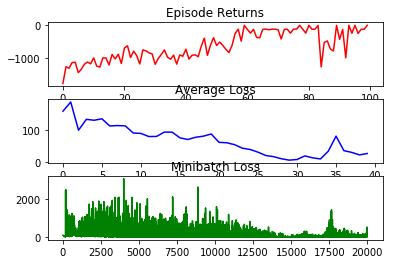

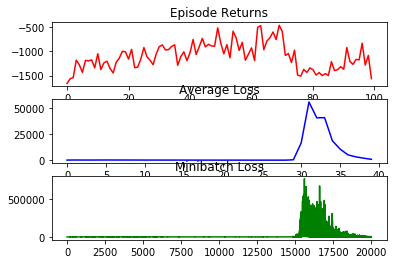

In [18]:
for ix in range(num_exp):
    fig, axes = plt.subplots(3)
    axes[0].plot(data_returns[ix], color=colors[0])
    axes[1].plot(data_average_loss[ix], color=colors[1])
    axes[2].plot(data_minibatch_loss[ix], color=colors[2])
    for i in range(3):
        axes[i].set_title(labels[i])

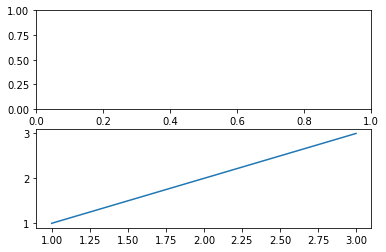

In [29]:
fig, ax = plt.subplots(2)
ax[1].plot([1,2,3], [1,2,3])

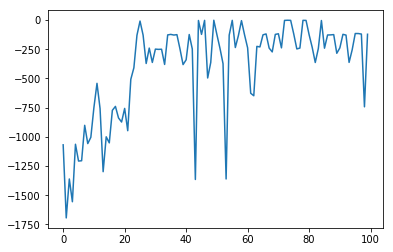

In [14]:
plt.plot(log_returns)

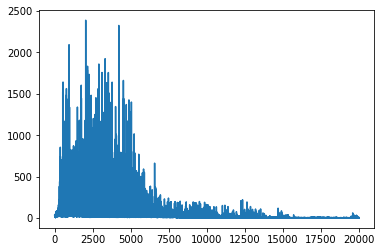

In [15]:
plt.plot(log_minibatch_loss)

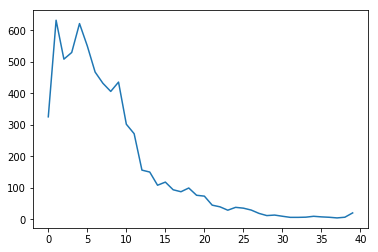

In [16]:
plt.plot(log_average_loss)

In [20]:
done = False
episode_reward = 0
observation = env.reset()
t_step = 0

while not done:
    t_step += 1
    env.render()
    input_state = torch.tensor([observation], dtype=torch.float32)
    action_idx = get_action(q_net, input_state, 0.01)
    observation, reward, done, info = env.step([action_list[action_idx]])
    
    episode_reward += reward

env.close()

print('Episode Score:', episode_reward)
print(t_step, 'time steps.')

Episode Score: -123.03763603784603
200 time steps.


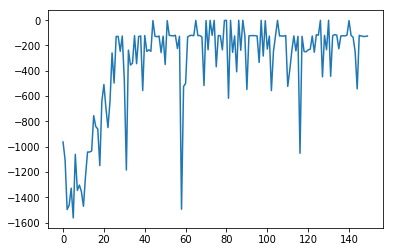

In [11]:
plt.plot(log_returns)

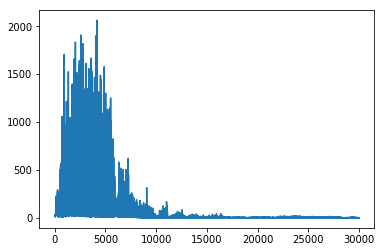

In [12]:
plt.plot(log_minibatch_loss)

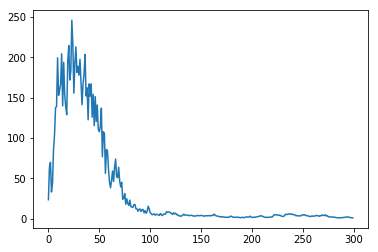

In [13]:
plt.plot(log_average_loss)

In [15]:
done = False
episode_reward = 0
observation = env.reset()
t_step = 0

while not done:
    t_step += 1
    env.render()
    input_state = torch.tensor([observation], dtype=torch.float32)
    action_idx = get_action(q_net, input_state, 0.01)
    observation, reward, done, info = env.step([action_list[action_idx]])
    
    episode_reward += reward

env.close()

print('Episode Score:', episode_reward)
print(t_step, 'time steps.')

Episode Score: -116.53112375395433
200 time steps.
